C:\Users\lvjt\AppData\Local\Temp\ipykernel_6788\4018175223.py:65: RuntimeWarning: overflow encountered in ushort_scalars
  ypre = y[j + i * w] - img_re[j + i * w - 1]  # 计算预测误差


51.143987183868596
22.227612975869484
11.294409368619343
10.530974240874539


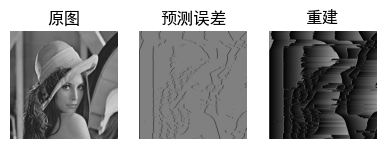

In [3]:
import cv2
import numpy as np
import io
from skimage.metrics import peak_signal_noise_ratio
def main(ratio):
    ###############################################################################
    # 读取图片，并转换为 y,v, u 分量。
    img = cv2.imread(r'../assest/lean.jpg')
    h, w = img.shape[:2]  # 高，宽

    # 将 BGR 转换为 YCrCb（YCrCb 应用 YCrCb JPEG（或 YCC），“全范围”，
    # 其中 Y 范围为 [0, 255]，U、V 范围为 [0, 255]（这是默认的 JPEG 格式颜色空间格式）。

    yvu = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, v, u = cv2.split(yvu)

    # 下采样 U 和 V（应用 420 格式）。
    u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))  # 要注意 w或h 为单数的情况
    v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))

    ############################################################################
    # 打开内存中的字节流（而不是使用 文件）
    # 将 Y、U 和 V 写入“流”。之后就可以以字节的形式读取，
    # 这个是为了模拟读取YUV文件的情况，直接由上面的yuv分量转换形状为一维数据应该也可以
    # 这样做的原因是我在网上找的DPCM的C语言版本都是直接读取 .yuv文件的，我为了遵循他们，就这么处理了（其实是懒。。）

    f = io.BytesIO()

    # Write Y, U and V to the "streams".
    f.write(y.tobytes())
    f.write(u.tobytes())
    f.write(v.tobytes())
    f.seek(0)

    img_np = np.frombuffer(f.read(), np.uint8)  # 原图的yuv420,一定要420,要不然要修改数组截取大小

    img_yuv_len = img_np.size
    img_y_len = h * w

    y = img_np[:img_y_len]
    u = img_np[img_y_len:(img_yuv_len - img_y_len) // 2 + img_y_len]  # 要注意 w或h 为单数的情况
    v = img_np[(img_yuv_len - img_y_len) // 2 + img_y_len:]
    # print(img_np.size)  # 16328
    ############################################################################
    # DPCM量化编码，采用边编码，边解码的形式，核心是下面for循环部分
    img_re = np.zeros(img_y_len, np.uint16)  # 用来存储重建图像,因为中间计算可能超过255，先用16，后面转回8
    yprebuff = np.zeros(img_y_len, np.uint16)  # 预测
    # print(prebuff.size) # 8164
    # print(prebuff.shape) # (8164,)

    radio=512/(1<<ratio)  # //量化因子  8是左向预测8bit量化，如果要进行4或2等的自行更改
    for i in range(h):
        for j in range(w):
            # 左向预测8bit量化
            if j == 0:
                # 每行第一个像素要进行特殊处理，或保留，或进行一定预测，本设计中是做一定变换预测
                ypre = y[j + i * w]-128  # 计算预测误差
                yprebuff[j + i * w] = (ypre+255)/radio  # 量化预测误差
                img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+128  # 重建像素,j解码
                if img_re[j + i * w]>255:
                    img_re[j + i * w] = 255# 防止重建像素超过255
                yprebuff[j + i * w] = yprebuff[j + i * w]*radio/2

            else:
                ypre = y[j + i * w] - img_re[j + i * w - 1]  # 计算预测误差
                yprebuff[j + i * w] = (ypre+255) /radio  # 量化  # 量化器
                img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+img_re[j + i * w - 1]  # 反量化
                yprebuff[j + i * w] = yprebuff[j + i * w] * radio / 2  # 预测器
                if img_re[j + i * w]>255:
                    img_re[j + i * w] = 255# 防止重建电平超过255
    img_re = img_re.astype(np.uint8) # 用来存储重建图像,后面转回uint8
    yprebuff = yprebuff.astype(np.uint8)  # 预测误差

    ##########################################################################################
    # 重建图片
    y = y.reshape((h,w))  # 转换向量形状回原来的y分量

    yprebuff = yprebuff.reshape((h,w))  # 预测的y分量

    img_re = img_re.reshape((h,w))  # 重建的y分量

    u = u.reshape((h//2,w//2))  # 恢复采样后的u分量
    v = v.reshape((h//2,w//2))
    ru = cv2.resize(u,(w,h))  # 恢复采样前的u分量，用这个u分量来重建图片文件
    rv = cv2.resize(v,(w,h))

    yvu = cv2.merge((y, rv, ru))
    bgr = cv2.cvtColor(yvu, cv2.COLOR_YCrCb2BGR)  # 将原来的y,u,v分量转换回图片

    yvu_pre = cv2.merge((yprebuff, rv, ru))
    bgr_pre = cv2.cvtColor(yvu_pre, cv2.COLOR_YCrCb2BGR)  # 将y的预测误差转换为图片

    yvu_re = cv2.merge((img_re, rv, ru))
    bgr_re = cv2.cvtColor(yvu_re, cv2.COLOR_YCrCb2BGR)  # 将解码后的的y,u,v分量转换回原图

    ###############################################################################
    print(peak_signal_noise_ratio(bgr,bgr_re))
    # 显示结果
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    plt.subplot(241), plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)),
    plt.title('原图'), plt.axis('off')
    plt.subplot(242), plt.imshow(cv2.cvtColor(bgr_pre, cv2.COLOR_BGR2RGB), cmap='gray'),
    plt.title('预测误差'), plt.axis('off')
    plt.subplot(243), plt.imshow(cv2.cvtColor(bgr_re, cv2.COLOR_BGR2RGB), cmap='gray'),
    plt.title('重建'), plt.axis('off')

main(8)
main(4)
main(2)
main(1)